#  Exploratory Data Analysis
 
 
 


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Clean Obfuscated ATM Data.csv')
df['Terminal DateTime'] = pd.to_datetime(df['Terminal DateTime']) 
df.set_index(df['Terminal DateTime'], inplace=True)
df

,Customer_id,Terminal DateTime,TranType,Term Seq.,Response,Issuer,amount_requested,amount_dispensed,fee_requested,fee_charged
Terminal DateTime,,,,,,,,,,
2020-07-13 16:53:39,7153195435530621939,2020-07-13 16:53:39,W/D,649.0,Liable,PUL,40,40.0,3.0,3.0
2020-07-13 18:02:29,3617705962654528737,2020-07-13 18:02:29,STL,NaN,Approved,NaN,NaN,NaN,0.0,0.0
2020-07-31 01:04:06,7929763781525975567,2020-07-31 01:04:06,W/D,746.0,Liable,MS0,140,140.0,3.0,3.0
2020-07-31 12:28:46,3617705962654528737,2020-07-31 12:28:46,STL,NaN,Approved,NaN,NaN,NaN,0.0,0.0
2020-08-07 18:41:10,3617705962654528737,2020-08-07 18:41:10,STL,NaN,Approved,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-12-06 13:09:11,1190346791087523935,2020-12-06 13:09:11,W/D,1471.0,Approved,SNE,200,200.0,3.0,3.0
2020-12-06 13:10:10,1190346791087523935,2020-12-06 13:10:10,W/D,1472.0,EXC WD L,SNE,200,NaN,0.0,0.0
2021-03-20 05:03:09,2183744640601740186,2021-03-20 05:03:09,W/D,2138.0,Approved,PUL,120,120.0,3.0,3.0


### How large is our data?

In [47]:

print(f'Sample Start: {df.index.min()}')
print(f'Sample End: {df.index.max()}')
print(f'Total Days: {(df.index.max() - df.index.min()).days}')

Sample Start: 2020-07-06 14:56:06
Sample End: 2021-08-09 23:05:31
Total Days: 399


In [48]:
df.shape
# there were 2751 balance checks and withdrawls and failed withdrawls in this period

(2751, 10)

In [49]:
transaction_df = df[df['fee_charged'] != 0.0] # A subset of all the valid transactions
transaction_df.shape # there were 1562 transactions in 399 days. 

(1562, 10)

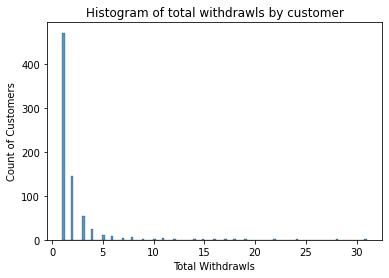

In [50]:
repeat_customers = transaction_df['Customer_id'].value_counts().values
sns.histplot(repeat_customers)
plt.title("Histogram of total withdrawls by customer")
plt.ylabel('Count of Customers')
plt.xlabel('Total Withdrawls')
plt.show()


Most customer only use the ATM once, but there are a handful of customers that have used the ATM many ones

In [51]:
total_unique_customers = len(transaction_df['Customer_id'].unique())

number_of_5_plus_repeat_customers = np.sum(transaction_df['Customer_id'].value_counts() >=5)
number_of_5_plus_repeat_customers

print(f'Percent of customers that have used the ATM 5+ times: {round((number_of_5_plus_repeat_customers/total_unique_customers)*100,2)}%')

Percent of customers that have used the ATM 5+ times: 7.07%


In [52]:
customer_group_df = transaction_df.groupby('Customer_id').sum().sort_values(by='fee_charged', ascending=False)
customer_group_df

,Term Seq.,amount_dispensed,fee_requested,fee_charged
Customer_id,,,,
5160764800030931563,25888.0,3880.0,93.0,93.0
6151147783377518261,46305.0,4620.0,84.0,84.0
3187606172919100028,67084.0,2500.0,69.0,72.0
1079720515450814901,29098.0,4000.0,66.0,66.0
3041864323038578142,44785.0,2260.0,57.0,57.0
...,...,...,...,...
3654563181889187262,2117.0,200.0,3.0,3.0
3721972177733772809,2579.0,40.0,3.0,3.0
3725547917346005929,1003.0,200.0,3.0,3.0


In [53]:
fifty_most_freqent_users = list(customer_group_df.index[:50])

fifty_most_freqent_users[:3]

[5160764800030931563, 6151147783377518261, 3187606172919100028]

The customer `5160764800030931563` spent $93 on ATM fees in slighly more than a year. 

# What are the patterns in the most frequent users

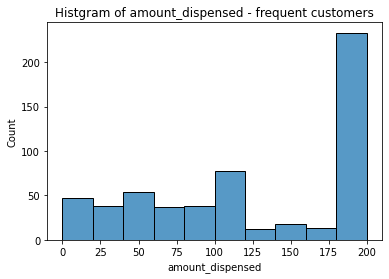

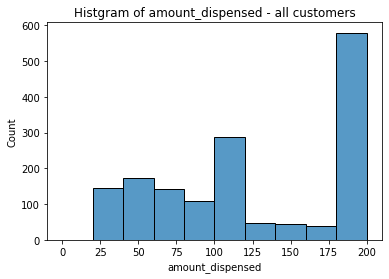

In [56]:
most_freqent_customers_df = df[df['Customer_id'].isin(fifty_most_freqent_users)]
plt.title('Histgram of amount_dispensed - frequent customers')
sns.histplot(most_freqent_customers_df['amount_dispensed'], bins=[a for a in range(0,220,20)])
plt.show()
plt.title('Histgram of amount_dispensed - all customers')
sns.histplot(transaction_df['amount_dispensed'], bins=[a for a in range(0,220,20)])
plt.show()

# How does transaction volume change over time?

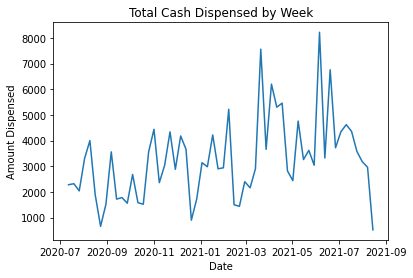

In [57]:
weekly_sum = transaction_df.resample('W').sum() # group by week. 
sns.lineplot(x='Terminal DateTime', y='amount_dispensed', data=weekly_sum)
plt.title('Total Cash Dispensed by Week')
plt.ylabel('Amount Dispensed')
plt.xlabel('Date')
plt.show()

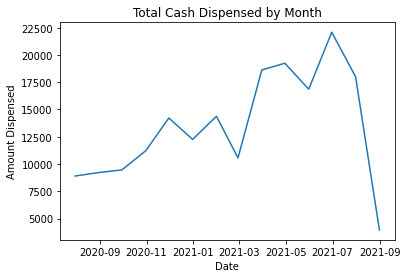

In [23]:
monthly_sum = transaction_df.resample('M').sum() 
sns.lineplot(x='Terminal DateTime', y='amount_dispensed', data=monthly_sum)
plt.title('Total Cash Dispensed by Month')
plt.ylabel('Amount Dispensed')
plt.xlabel('Date')
plt.show()

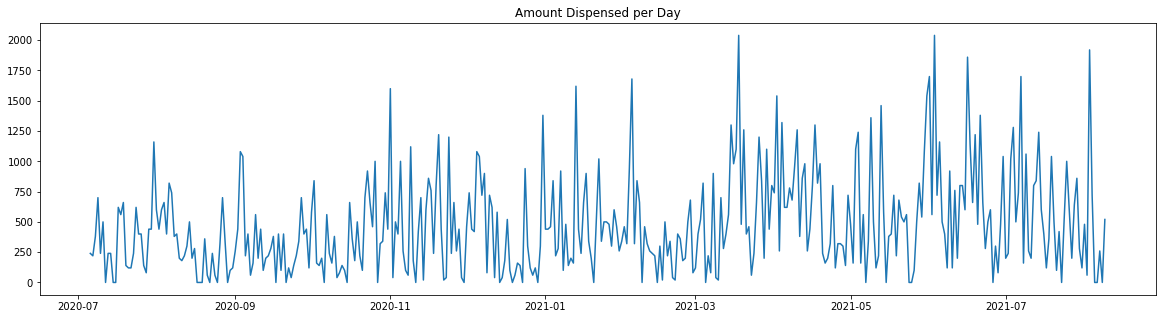

In [71]:
plt.figure(figsize=(20, 5))
plt.plot(transaction_df['amount_dispensed'].resample('D').sum())
plt.title('Amount Dispensed per Day')
plt.show()

# This data is very noisey

In [82]:
mean = round(transaction_df['amount_dispensed'].resample('D').sum().mean(),2)
std = round(transaction_df['amount_dispensed'].resample('D').sum().std(),2)

print(f'Average cash withdrawn was ${mean}')
print(f'STD of daily cash withdrawn was ${std}')


Average cash withdrawn was $472.45
STD of daily cash with drawn was $403.36


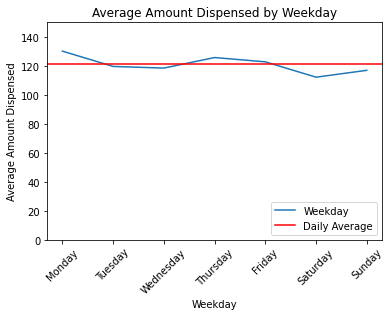

In [20]:
weekday = transaction_df.groupby(transaction_df.index.weekday).mean()
average_daily_cash_dispensed = transaction_df['amount_dispensed'].mean()

weekday.reset_index(inplace=True)
weekday['Terminal DateTime'] = pd.Index(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
weekday.set_index('Terminal DateTime')
sns.lineplot(x='Terminal DateTime', y='amount_dispensed', data=weekday)
plt.title('Average Amount Dispensed by Weekday')
plt.axhline(y=average_daily_cash_dispensed, color='r', linestyle='-', label='Daily Average')
plt.ylim(0,150)
plt.ylabel('Average Amount Dispensed')
plt.xlabel('Weekday')
plt.xticks(rotation = 45)
plt.legend(['Weekday', 'Daily Average'], loc='lower right')
plt.show()

Weekday only has a neglible influence on the daily amount of cash dispensed with Monday, Thrusday and Friday having slighly greater than average amount dispensed.

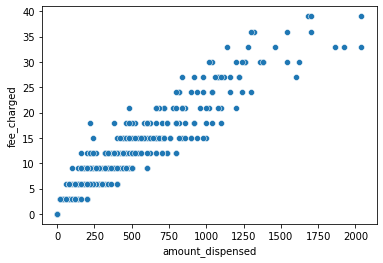

,amount_dispensed,fee_charged,weekday,month
Terminal DateTime,,,,
2020-07-06,240.0,9.0,0,<bound method inherit_from_data.<locals>.metho...
2020-07-07,220.0,18.0,1,<bound method inherit_from_data.<locals>.metho...
2020-07-08,380.0,18.0,2,<bound method inherit_from_data.<locals>.metho...
2020-07-09,700.0,15.0,3,<bound method inherit_from_data.<locals>.metho...
2020-07-10,240.0,6.0,4,<bound method inherit_from_data.<locals>.metho...
...,...,...,...,...
2021-08-05,0.0,0.0,3,<bound method inherit_from_data.<locals>.metho...
2021-08-06,0.0,0.0,4,<bound method inherit_from_data.<locals>.metho...
2021-08-07,260.0,9.0,5,<bound method inherit_from_data.<locals>.metho...


In [65]:
features = ['amount_dispensed','fee_charged'] # extract only valid transactions
feature_df = df[features]
feature_df = feature_df.resample('D').sum() # daily totals

feature_df['weekday'] = feature_df.index.weekday
feature_df['month'] = feature_df.index.month_name
feature_df

sns.scatterplot(x='amount_dispensed', y='fee_charged', data=feature_df)
plt.show()


There is a positive corrilation between amount dispensed and the fee charged. The varience tends to increase as the amount dispened inceases. This makes senes it is what you would expect since each customer can withdrawl different amounts of cash.